In [10]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
print('import finish')

import finish


In [59]:
datasets_dir = 'datasets'
checkpoint_dir = 'checkpoints'

In [12]:
joint_number = 5

In [13]:
datasets = []
for file_name in list(os.listdir(datasets_dir)):
    dataset = pd.read_table(f'{datasets_dir}/{file_name}', sep=' ')
    datasets.append(dataset)


In [14]:
def remove_outliers(df, column=None):
    if column is None:
        return df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    return df[(np.abs(stats.zscore(df[column])) < 3).all(axis=1)]

In [15]:
full_datasets = []
for dataset in datasets:
    time = dataset["time"]
    col_names_vel = [el for el in datasets[0].columns if el.startswith("Vel")]
    velocities = dataset[col_names_vel]
    diff_v = np.diff(velocities, axis=0)
    diff_t = np.diff(time, axis=0)
    col_names_acc = [el.replace("Vel", "Acc") for el in col_names_vel]
    acc = pd.DataFrame(
        np.transpose(np.transpose(diff_v) / diff_t), columns=col_names_acc
    )
    dataset_with_acc = (dataset.join(acc))[:-1]
    dataset_with_acc = remove_outliers(
        dataset_with_acc,
        column=[el for el in datasets[0].columns if el.startswith("For")],
    )
    full_datasets.append(dataset_with_acc)

In [16]:
dataset = pd.concat(full_datasets)

In [17]:
print(dataset.shape)

(493762, 21)


In [18]:
def plot_(name, df, i=0, count=-1, start=0, title=None, file_name=None, directory=None):
    if title is None:
        title = name
    col = [el for el in df.columns if el.startswith(name)]
    val = df[col]
    i = val.iloc[start : start + count, i]
    plt.plot(range(len(i)), i, ".")
    plt.title(title)

    if directory is not None:
        if not os.path.exists(directory):
            os.makedirs(directory)

    if file_name is not None:
        plt.savefig(directory + "/" + file_name)

    plt.show()


# plot_('Pos', dataset, 0)
# plot_('Vel', dataset, 0)
# plot_('Acc', dataset, 0)
# plot_(
#     "For",
#     dataset,
#     1,
#     count=1000,
#     start=1000,
#     title="Force cleaned",
# )
# for i in range(2):
#     plot_('Vel', full_datasets[0], i)

# data preprocessing

In [19]:
df = dataset
# normalize
dataset = (df-df.min())/(df.max()-df.min())
dataset.pop('time')

1     0.135863
2     0.135863
3     0.135864
4     0.135865
5     0.135866
        ...   
36    0.859873
37    0.859874
38    0.859875
39    0.859875
40    0.859876
Name: time, Length: 493762, dtype: float64

In [20]:
def split_to_x_y(table):
    X_names = [el for el in table.columns if el.startswith('Pos') or el.startswith('Vel') or el.startswith('Acc')]
    Y_names = [el for el in table.columns if el.startswith('For')]
    return table[X_names], table[Y_names]

In [21]:
# divide dataset into train and test by fraction
def split_train_test(table, fraction):
    train_size = int(len(table) * fraction)
    return table[:train_size], table[train_size:]

In [22]:
train, test = split_train_test(dataset, 0.95)
(train_x, train_y), (test_x, test_y) = split_to_x_y(train), split_to_x_y(test)

In [23]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [24]:
def create_model(layers):
    model = Sequential()
    # input layer
    model.add(Flatten(input_shape=((joint_number * 3),)))
    for layer in layers:
        model.add(
        Dense(
            layer,
            activation="tanh",
        )
    )

    # output layer
    model.add(Dense(joint_number, activation="sigmoid"))

    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=[
            keras.metrics.RootMeanSquaredError("rmse"),
            'mae',
            r_square,
        ],
    )
    return model

In [72]:
layers_list = [
    #
    [50 for _ in range(4)],
    [50 for _ in range(5)],
    [50 for _ in range(6)],
    #
    [100 for _ in range(4)],
    [100 for _ in range(5)],
    [100 for _ in range(6)],
    #
    [200 for _ in range(4)],
    [200 for _ in range(5)],
    [200 for _ in range(6)],
    #
]

models = [create_model(layers) for layers in reversed(layers_list)]

In [73]:
histories = []
for i, model in enumerate(models):
    layers = layers_list[i]
    name = " ".join(map(str, layers))

    from datetime import datetime
    gen_date_str = datetime.now().strftime("-%Y-%m-%d_%H-%M-%S")

    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    if not os.path.exists(checkpoint_dir + '/' + name + gen_date_str):
        os.mkdir(checkpoint_dir + '/' + name + gen_date_str)

    filepath_backup = (
        checkpoint_dir + '/' + name + gen_date_str + "/epoch-{epoch:02d}-val_r_square-{val_r_square:.2f}.hdf5"
    )

    checkpoint_best = keras.callbacks.ModelCheckpoint(
        filepath_backup,
        monitor="val_r_square",
        mode="max",
        save_best_only=True,
        verbose=1,
    )

    histories.append(
        model.fit(
            train_x,
            train_y,
            epochs=200,
            validation_data=(test_x, test_y),
            callbacks=[
                EarlyStopping(patience=3, monitor="val_r_square", mode="max"),
                checkpoint_best,
            ],
        )
    )

Epoch 1/200
14653/14659 [============================>.] - ETA: 0s - loss: 0.0128 - rmse: 0.1130 - mae: 0.0840 - r_square: 0.8374
Epoch 1: val_r_square improved from -inf to 0.81291, saving model to checkpoints/50 50 50 50-2023-04-28_10-33-48/epoch-01-val_r_square-0.81.hdf5
14659/14659 [==============================] - 35s 2ms/step - loss: 0.0128 - rmse: 0.1130 - mae: 0.0840 - r_square: 0.8374 - val_loss: 0.0104 - val_rmse: 0.1021 - val_mae: 0.0757 - val_r_square: 0.8129
Epoch 2/200
14654/14659 [============================>.] - ETA: 0s - loss: 0.0098 - rmse: 0.0992 - mae: 0.0720 - r_square: 0.8748
Epoch 2: val_r_square improved from 0.81291 to 0.82432, saving model to checkpoints/50 50 50 50-2023-04-28_10-33-48/epoch-02-val_r_square-0.82.hdf5
14659/14659 [==============================] - 35s 2ms/step - loss: 0.0098 - rmse: 0.0992 - mae: 0.0720 - r_square: 0.8748 - val_loss: 0.0096 - val_rmse: 0.0981 - val_mae: 0.0701 - val_r_square: 0.8243
Epoch 3/200
14659/14659 [==================

In [74]:
for i, model in enumerate(models):
    layers = layers_list[i]
    name = dir = " ".join(map(str, layers))

    print(f"validation {name}:", model.evaluate(test_x, test_y))

772/772 [==============================] - 1s 1ms/step - loss: 0.0083 - rmse: 0.0910 - mae: 0.0625 - r_square: 0.8536
validation 50 50 50 50: [0.00828966312110424, 0.09104758501052856, 0.062489863485097885, 0.8535755276679993]
772/772 [==============================] - 1s 1ms/step - loss: 0.0087 - rmse: 0.0935 - mae: 0.0630 - r_square: 0.8366
validation 50 50 50 50 50: [0.00874666590243578, 0.09352358430624008, 0.0630112960934639, 0.8365582823753357]
772/772 [==============================] - 1s 1ms/step - loss: 0.0078 - rmse: 0.0882 - mae: 0.0590 - r_square: 0.8604
validation 50 50 50 50 50 50: [0.007785436697304249, 0.08823513239622116, 0.059021640568971634, 0.8604132533073425]
772/772 [==============================] - 1s 870us/step - loss: 0.0083 - rmse: 0.0913 - mae: 0.0624 - r_square: 0.8527
validation 100 100 100 100: [0.008327562361955643, 0.09125546365976334, 0.06242762878537178, 0.8527006506919861]
772/772 [==============================] - 1s 827us/step - loss: 0.0078 - rmse

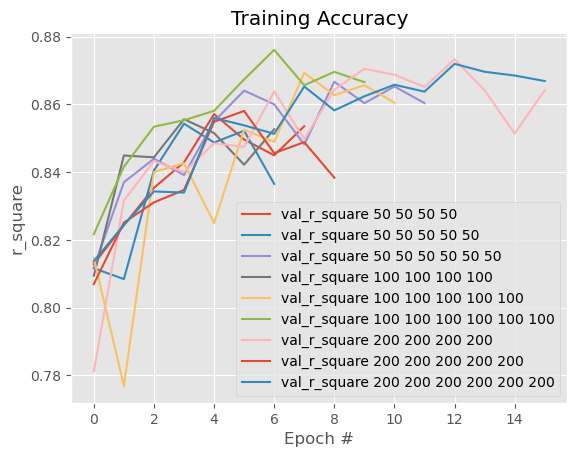

In [75]:
plt.style.use("ggplot")
plt.figure()
for i, model in enumerate(models):
    layers = layers_list[i]
    history = histories[i]
    name = dir = " ".join(map(str, layers))

    # plot the training loss and accuracy
    epochs = len(history.history["loss"])

    plt.plot(np.arange(0, epochs),
            history.history["val_r_square"], label=f"val_r_square {name}")
plt.title(f"Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("r_square")
plt.legend()